In [78]:
import pandas as pd
import os

threshold = 0

mapping  = "/data/projects/F1_genefusionval/file_mapping.txt"
mapping = pd.read_csv(mapping, sep="\t")
mapping.to_csv("mapping_initial.csv", index= True)
mapping.rename(columns={"file_id": "folder"}, inplace=True)
folder = "/data/projects/F1_genefusionval/out/STAR_fusion"
suffix ="_star-fusion.fusion_predictions.tsv"
output_dir = "test/"
files = os.listdir(folder)
files = [i for i in files if i.endswith(suffix)]

os.makedirs(output_dir, exist_ok=True)
for index, row in mapping.iterrows():
    folder_path = os.path.join("/data/projects/F1_genefusionval/data",row["folder"])
    file_names = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
    file_name = file_names[0]
    file_name = os.path.basename(file_name).split(".")[0]
    mapping.loc[index, "file_name"] = file_name

def average(lst):
    return sum(lst) / len(lst)


In [79]:
F1panel = pd.read_csv("F1panel.csv")["F1 Panel"].tolist()

onco_gene = pd.read_csv('./Onco.csv')
onco_gene = onco_gene["Oncogene"].tolist()

panelC = pd.read_csv('./appendixC.csv')
panelC = panelC["symbol"].tolist()

panel_to_filter = []
if panel_to_filter == []:
    panel_name = "all"

# TODO: limit genes in oncopanel/F1panel/panelC. If keep all genes, just comment out the following 2 lines
panel_to_filter = F1panel
panel_name = "F1panel"

In [80]:
fusion_dict = {}
pair_dict_our = {}

for file in files:
    df = pd.read_csv(os.path.join(folder, file), sep="\t")
    # JunctionReadCount  SpanningFragCount
    # df = df[df["SpanningFragCount"] >= threshold]
    df = df[~df['#FusionName'].isin(['C10orf68--CCDC7', 'CCDC7--C10orf68'])]
    pair_list = df["#FusionName"].tolist()
    pair_list = list(set(pair_list))  
    pair_list = [s.replace("-@-ext", "") for s in pair_list]
    pair_list = [s.replace("@-ext", "") for s in pair_list]


    gene_list = [part for item in pair_list for part in item.split("--")]
    fusion_dict[file.replace(suffix, "")] = list(set(gene_list)) 

    if panel_to_filter != []:
        filtered_pair_list = []
        for item in pair_list:
            parts = item.split('--')
            if parts[0] in panel_to_filter or parts[1]  in panel_to_filter:
                filtered_pair_list.append(item)
        pair_dict_our[file.replace(suffix, "")] = filtered_pair_list 
    else:
        pair_dict_our[file.replace(suffix, "")] = pair_list

    df["sample"] = file.replace(suffix, "")

print(pair_dict_our)


{'5eef868d-7c7f-42e8-aabf-ce3f75405c7a': ['RARA--CDC6'], 'c9f641bc-d9fe-4cd6-8e73-bbf6935aee52': [], '7a7440bf-1ca1-4c6b-80f8-7151a38e5d18': ['EML4--ALK'], 'd4422306-b68c-4687-9131-02a60a2d4c42': ['XPO7--ETV4'], '4e58c985-012a-4846-97f6-80dac0cae0b4': ['FGFR2--BICC1'], '6f6bf240-1ca4-47d0-9a77-17b0ce9b8ae7': ['RARA--STAC2'], 'fd98106a-a2c6-4f23-86f5-66436c2501e5': ['RARA--CH17-260O16.1'], '45209842-481c-487b-bc91-f3f2d0b8564d': ['ICE1--TERT'], '48e72b16-4249-4e35-94e0-cf96a6c1068a': ['MSH2--EPCAM'], '2b4652fb-eef5-427e-b4f0-24164c042e52': [], '4102816c-2ab8-4ecb-83b0-4f78c052bcd8': ['TRIM33--RET'], '36125e17-48fd-4eea-874c-ed2e2e218402': ['MYB--NFIB', 'HEATR5B--MYB'], '1b0ce868-c996-4684-8385-a6db580c75f5': ['CCAR2--FGFR2', 'FGFR2--CCAR2'], 'a37efe02-9662-4b90-8251-003ccb96aed4': ['PRPF6--SDC4', 'RARA--LGALS16'], '8b3aec43-4c75-4598-bf0a-168f7ffb9f3b': ['FBXO9--CD74', 'CD74--ROS1', 'ROS1--FBXO9', 'SLC34A2--RP11-302F12.3'], 'ce8c79f1-aebf-4824-aa7a-5eb528c7015a': ['FGFR3--TACC3'], '0781

In [81]:
our_df = pd.DataFrame()
count = 0
for file in files:
    df = pd.read_csv(os.path.join(folder, file), sep="\t")
    df = df[['#FusionName', 'JunctionReadCount', 'SpanningFragCount']]
    df['#FusionName'] = df['#FusionName'].apply(lambda x: x.replace("-@-ext", "") if isinstance(x, str) else x)
    df['#FusionName'] = df['#FusionName'].apply(lambda x: x.replace("@-ext", "") if isinstance(x, str) else x)
    df = df[~df['#FusionName'].duplicated(keep='first')]
    df = df[~df['#FusionName'].isin(['C10orf68--CCDC7', 'CCDC7--C10orf68'])]
    sample_name = file.replace(suffix, "")
    df["sample"] = sample_name
    our_df = pd.concat([our_df, df], axis=0)
    # print(our_df.shape)
    count = count + 1
    # if count > 25:
    #     break
    # print(stop)
    # JunctionReadCount  SpanningFragCount
    

In [82]:
def remove_spaces(s):
    return s.replace(" ", "")

mapping = mapping.applymap(remove_spaces)
mapping = mapping[~mapping['submitter'].duplicated(keep=False)]
print(mapping.shape)

duplicateRowsDF = mapping[mapping['submitter'].duplicated(keep=False)]
duplicateRowsDF = duplicateRowsDF["submitter" ].tolist()  
print(duplicateRowsDF)


(118, 3)
[]


In [83]:
this_cancer = "drop"
this_cancer = "KIRC"
cancer_type = pd.read_excel("cancer type.xlsx")
for index, row in cancer_type.iterrows():
    row["unique"] = '-'.join(row["unique"].split('-')[:3])
types = cancer_type["Cancer Types"].tolist()
types = list(set(types))
types.sort()
print(types)
type = pd.DataFrame(types, columns=["Cancer Types"])
type["count"] = 0
cancer_type.head()
# this_samples = cancer_type[cancer_type["Cancer Types"] == "KIRC"]["unique"].tolist()
# mapping = mapping[~mapping["submitter"].isin(this_samples)]


['BRCA', 'COAD', 'KIRC', 'LIHC', 'LUAD', 'LUSC', 'SARC', 'STAD', 'UCEC', 'UCS']


,unique,Cancer Types
0,TCGA-B6-A0RH,BRCA
1,TCGA-A2-A04W,BRCA
2,TCGA-EW-A1IW,BRCA
3,TCGA-DD-AACL,LIHC
4,TCGA-55-6543,LUAD


In [102]:
gene_mapping = {"C10orf26": "WBP1L", "C6orf186": "C6orf186", "C7orf10": "SUGCT", "C4orf14": "C4orf14",
           "C20orf177": "FAM217B", "C14orf37": "ARMH4", "C17orf108": "LYRM9", "C19orf2": "URI1",
           "C8orf38": "NDUFAF6", "C17orf39": "GID4", "C17orf63": "FAM222B", "C6orf35": "TMEM242","KIAA1967":"CCAR2",
           "KIAA0947":"ICE1" }

bigdata = pd.read_excel("Big Data.xlsx")
bigdata['Gene_A'] = bigdata['Gene_A'].replace(gene_mapping)
bigdata['Gene_B'] = bigdata['Gene_B'].replace(gene_mapping)
print(bigdata.shape)
# print(bigdata["Gene_A"].isin(onco_gene))
if panel_to_filter != []:
    bigdata = bigdata[(bigdata["Gene_A"].isin(panel_to_filter))| (bigdata["Gene_B"].isin(panel_to_filter)) ]
    print(bigdata.shape)

# print(bigdata.columns)
bigdata = bigdata[["Sample", "Gene_A", "Gene_B",'Discordant Read Pairs','Junction Spanning Reads', 'Number of Junctions']]
bigdata = bigdata[~(((bigdata['Gene_A'] == 'C10orf68') & (bigdata['Gene_B'] == 'CCDC7')) |
          ((bigdata['Gene_A'] == 'CCDC7') & (bigdata['Gene_B'] == 'C10orf68')))]
bigdata = bigdata[~(bigdata['Gene_A'].str.contains('00:00:00') | bigdata['Gene_B'].str.contains('00:00:00'))]

bigdata = bigdata[bigdata["Junction Spanning Reads"] >= threshold]
their_dict = {}
pair_dict_their = {}
for index, row in bigdata.iterrows():
    sample = '-'.join(row["Sample"].split('-')[:3])
    their_dict[sample] = []
    pair_dict_their[sample] = []
for index, row in bigdata.iterrows():
    sample = '-'.join(row["Sample"].split('-')[:3])
    their_dict[sample].append(row["Gene_A"])
    their_dict[sample].append(row["Gene_B"])

    pairlist = []
    pairlist =pairlist + [f'{row["Gene_A"]}--{row["Gene_B"]}']   # , f'{row["Gene_B"]}--{row["Gene_A"]}'
    pair_dict_their[sample] = pair_dict_their[sample] + pairlist

print(their_dict)
print(fusion_dict)
print(list(fusion_dict.keys()))
print(list(their_dict.keys()))

(20731, 17)
(642, 17)
{'TCGA-OR-A5J1': ['MLL', 'ATP5L'], 'TCGA-OR-A5J7': ['RAF1', 'TMEM40'], 'TCGA-OR-A5JS': ['CCDC47', 'TERT'], 'TCGA-2F-A9KP': ['RAF1', 'IQSEC1'], 'TCGA-BT-A2LA': ['MLL', 'SLC22A10'], 'TCGA-DK-A6B5': ['RAF1', 'NXPH1'], 'TCGA-FD-A43N': ['BCR', 'PPIL2'], 'TCGA-GC-A6I3': ['EGFR', 'GRB10'], 'TCGA-GV-A3QG': ['TPM1', 'ALK'], 'TCGA-K4-A3WV': ['BRAF', 'MRPS33'], 'TCGA-XF-A9T5': ['CD74', 'CD40'], 'TCGA-A1-A0SB': ['HEATR5B', 'MYB', 'MYB', 'NFIB'], 'TCGA-A2-A04U': ['MSH2', 'SLC3A1'], 'TCGA-A2-A04W': ['RARA', 'CDK12'], 'TCGA-A2-A0CY': ['EZR', 'RB1CC1'], 'TCGA-A2-A0D4': ['RARA', 'PCTP'], 'TCGA-A2-A0ST': ['ATP1A1', 'NOTCH2'], 'TCGA-A2-A0T3': ['ETV4', 'CCL16'], 'TCGA-A2-A0YG': ['RARA', 'PRR11'], 'TCGA-A2-A3XS': ['AHI1', 'MYB'], 'TCGA-A7-A13D': ['BCL2L14', 'ETV6'], 'TCGA-A7-A26G': ['MSH2', 'TTC7A'], 'TCGA-A7-A4SD': ['ADAMTS16', 'ETV6'], 'TCGA-A8-A08B': ['RARA', 'PGAP3'], 'TCGA-A8-A09I': ['RARA', 'MYO1D'], 'TCGA-A8-A0A7': ['RARA', 'CA10'], 'TCGA-AN-A0FV': ['RARA', 'PCTP'], 'TCGA-AO-A1

In [85]:
our_df = pd.DataFrame()
count = 0
for file in files:
    df = pd.read_csv(os.path.join(folder, file), sep="\t")
    df = df[['#FusionName', 'JunctionReadCount', 'SpanningFragCount']]
    df['#FusionName'] = df['#FusionName'].apply(lambda x: x.replace("-@-ext", "") if isinstance(x, str) else x)
    df['#FusionName'] = df['#FusionName'].apply(lambda x: x.replace("@-ext", "") if isinstance(x, str) else x)
    df = df[~df['#FusionName'].duplicated(keep='first')]
    df = df[~df['#FusionName'].isin(['C10orf68--CCDC7', 'CCDC7--C10orf68'])]
    sample_name = file.replace(suffix, "")
    df["sample"] = sample_name
    our_df = pd.concat([our_df, df], axis=0)
    # print(our_df.shape)
    count = count + 1
    # if count > 25:
    #     break
    # print(stop)
    # JunctionReadCount  SpanningFragCount
their_df = bigdata
their_df["sample"] = their_df["Sample"].apply(lambda x: '-'.join(x.split('-')[:3]))
their_df = their_df.drop(columns=['Sample'])
print(their_df.head())

     Gene_A    Gene_B  Discordant Read Pairs  Junction Spanning Reads  \
7       MLL     ATP5L                     14                        6   
41     RAF1    TMEM40                     70                       41   
97   CCDC47      TERT                      3                        2   
245    RAF1    IQSEC1                     11                        7   
394     MLL  SLC22A10                      2                        3   

     Number of Junctions        sample  
7                      2  TCGA-OR-A5J1  
41                     4  TCGA-OR-A5J7  
97                     1  TCGA-OR-A5JS  
245                    1  TCGA-2F-A9KP  
394                    3  TCGA-BT-A2LA  


In [87]:
# output and generate table
result_data = []
additional_list = []
unfound_count = 0

hist_fusion = []

import copy

unique_detected_fusions = []
unique_expected_fusions = []

for index, row in mapping.iterrows():
    file_id = row["file_name"]
    submitter = row["submitter"]
    if submitter not in list(pair_dict_their.keys()) or file_id not in list(pair_dict_our.keys()):
        unfound_count = unfound_count + 1
        continue

    their_list = pair_dict_their[submitter]
    hist_fusion = hist_fusion + their_list
    our_list = pair_dict_our[file_id]
    intersection = list(set(our_list).intersection(set(their_list)))

    unique_detected_fusions = unique_detected_fusions + intersection
    unique_expected_fusions = unique_expected_fusions + their_list

    this_dict = {}
    this_dict["sample"] = submitter
    this_cancer_type = cancer_type.loc[cancer_type['unique'] == submitter, 'Cancer Types'].tolist()
    if this_cancer_type == []:
        this_cancer_type = ["Unknown"]
    their_list.sort()

    # here we add () to the fusions that are common in detected list and expected list
    expected = copy.deepcopy(their_list)
    for i in range(len(expected)):
        if expected[i] in our_list:
            expected[i] = "(" + expected[i] + ")"

    our_list.sort()
    detect = copy.deepcopy(our_list)
    for i in range(len(detect)):
        if detect[i] in their_list:
            detect[i] = "(" + detect[i] + ")"
            
    this_dict["cancer type"] = f"{this_cancer_type[0]}"
    type.loc[type['Cancer Types'] == this_cancer_type[0], 'count'] = type.loc[type['Cancer Types'] == this_cancer_type[0], 'count'] + 1
    this_dict["expected fusion"] = ", ".join(expected)
    this_dict["detected fusion"] = ", ".join(detect)
    this_dict["undetected fusions"] = ", ".join(list(set(their_list) - set(intersection)))
    this_dict["#detected"] = len(intersection)
    this_dict["#expected"] = len(their_list)
    this_dict["detected rata by sample"] = len(intersection)/len(their_list)
    addtional_fusions = list(set(our_list) - set(intersection))
    additional_list = additional_list + addtional_fusions
    this_dict["additional fusion"] = ", ".join(list(set(our_list) - set(intersection)))
    this_dict["number of additional fusion"] = len(list(set(our_list) - set(intersection)))
    result_data.append(this_dict)
result_data = pd.DataFrame(result_data) 

unique_detected_fusions = list(set(unique_detected_fusions))
unique_expected_fusions = list(set(unique_expected_fusions))

result_data.to_excel(output_dir + f"result_data_{panel_name}.xlsx", index=False)
print(panel_name)
print(f"number of samples included: {result_data.shape[0]}")
print(f"expected fusions: {sum(result_data['#expected'])}")
print(f"detected fusions: {sum(result_data['#detected'])}")
print(f"overall detected rate: {sum(result_data['#detected'])/sum(result_data['#expected']):.2%}")
print(f"overall detected rate (unique): {len(unique_detected_fusions)}/{len(unique_expected_fusions)} = {len(unique_detected_fusions)/len(unique_expected_fusions):.2%}")
print(f"average detected rate by sample: {average(result_data['detected rata by sample']):.2%}")
print(f"number of unique additional fusion: {len(set(additional_list))}")
print(f"number of all additional fusion: {len((additional_list))}")
print(f"average number of additional fusion: {average(result_data['number of additional fusion'])}")
print(f"number of samples not included: {unfound_count}")
add_fusion_in_C = []
for fusion in additional_list:
    if fusion.split("--")[0] in panelC or fusion.split("--")[1] in panelC:
        add_fusion_in_C.append(fusion)

# print the frequency  打印存在于onco_list中的元素在additional_list中的出现次数

print("additional fusions in appendix C:", len(add_fusion_in_C))
print("additional fusions in appendix C (unique):", len(list(set(add_fusion_in_C))))

F1panel
number of samples included: 117
expected fusions: 123
detected fusions: 99
overall detected rate: 80.49%
overall detected rate (unique): 85/108 = 78.70%
average detected rate by sample: 79.49%
number of unique additional fusion: 26
number of all additional fusion: 29
average number of additional fusion: 0.24786324786324787
number of samples not included: 1
additional fusions in appendix C: 28
additional fusions in appendix C (unique): 25


['RARA--STAC2', 'FGFR3--TACC3', 'TRIM33--RET', 'EML4--ALK', 'XPO7--ETV4', 'TRIM24--NTRK2', 'ETV6--PLEKHG6', 'TNFRSF6B--CD74', 'SLC34A2--EEA1', 'EML4--ALK', 'CD74--ROS1', 'SLC34A2--NDUFV1', 'ICE1--TERT', 'FGFR3--TACC3', 'ARID2--TMPRSS2', 'BCL2L14--ETV6', 'NOTCH2--CWH43', 'RAF1--TMEM40', 'MYH9--CD74', 'PDCD6--TERT', 'TMPRSS2--PHF12', 'CD74--THSD4', 'SLC7A2--TERT', 'SDC4--AP1G2', 'FGFR1--SLC20A2', 'ZNF675--BRCA1', 'EML4--ALK', 'SDC4--TSHZ2', 'RARA--PCTP', 'MSH2--SLC3A1', 'AIM1--MYB', 'RARA--MYO1D', 'RARA--SKAP1', 'ETV6--NTRK3', 'ATP1A1--NOTCH2', 'RARA--PGAP3', 'RARA--WIPF2', 'FGFR2--CCDC6', 'MSH2--TTC7A', 'BCR--MOV10L1', 'DPM1--EZR', 'RARA--HOXB3', 'RARA--CDK12', 'TPCN2--RARA', 'FBXL20--NOTCH2', 'RARA--MSL1', 'PTGFRN--NOTCH2', 'HEATR5B--MYB', 'MYB--NFIB', 'MAGI3--NOTCH2', 'RARA--ZNF595', 'ARMH4--RSPO2', 'ETV6--NTRK3', 'ETV6--NTRK3', 'RARA--LYRM9', 'TMPRSS2--SETD4', 'ETV5--DGKG', 'SLC12A7--TERT', 'RNF43--RARA', 'ETV6--APOLD1', 'NDUFAF6--MYC', 'BRAF--MRPS33', 'MSH2--EPCAM', 'SDC4--TP53TG5',

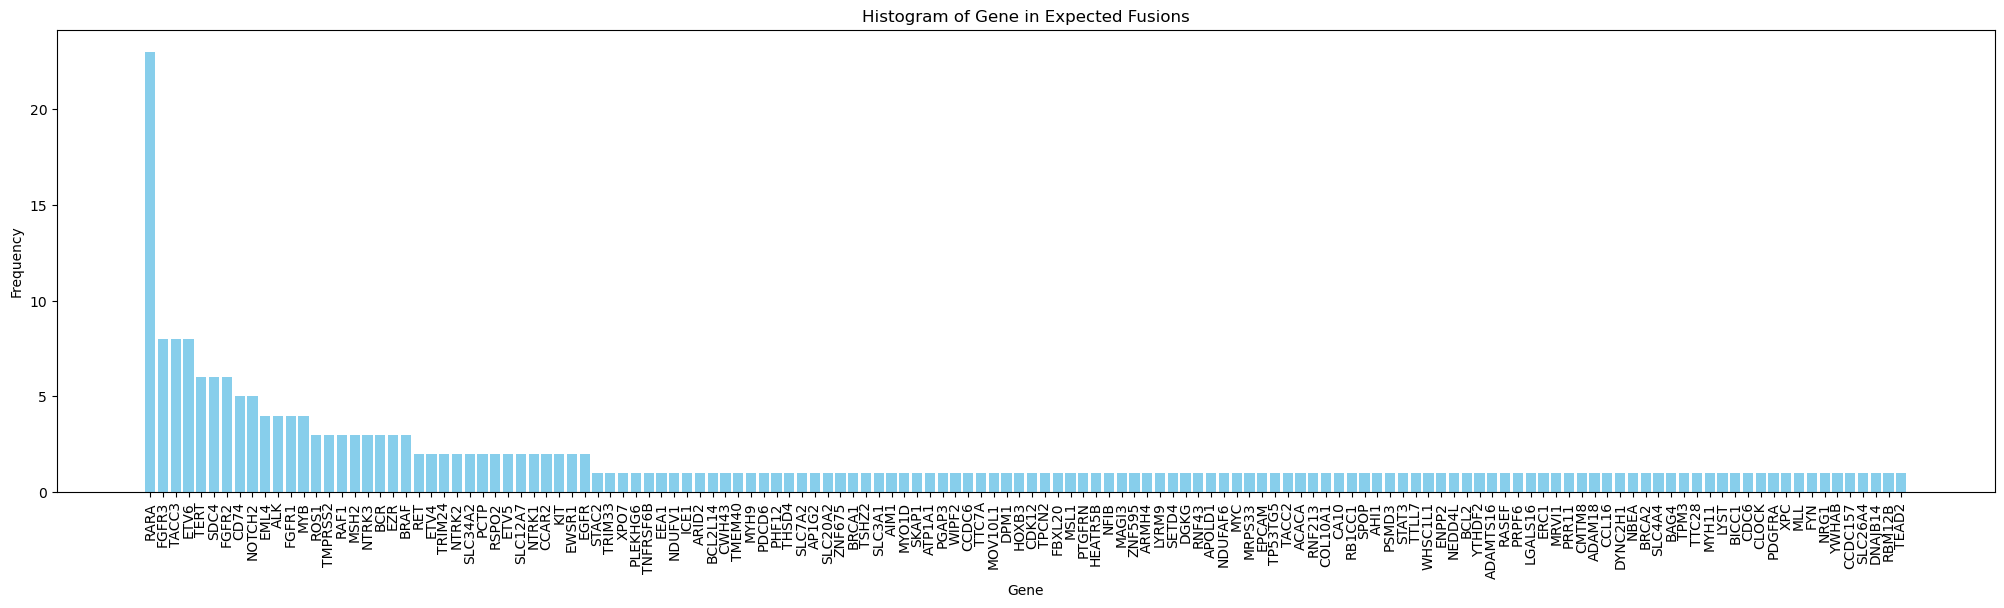

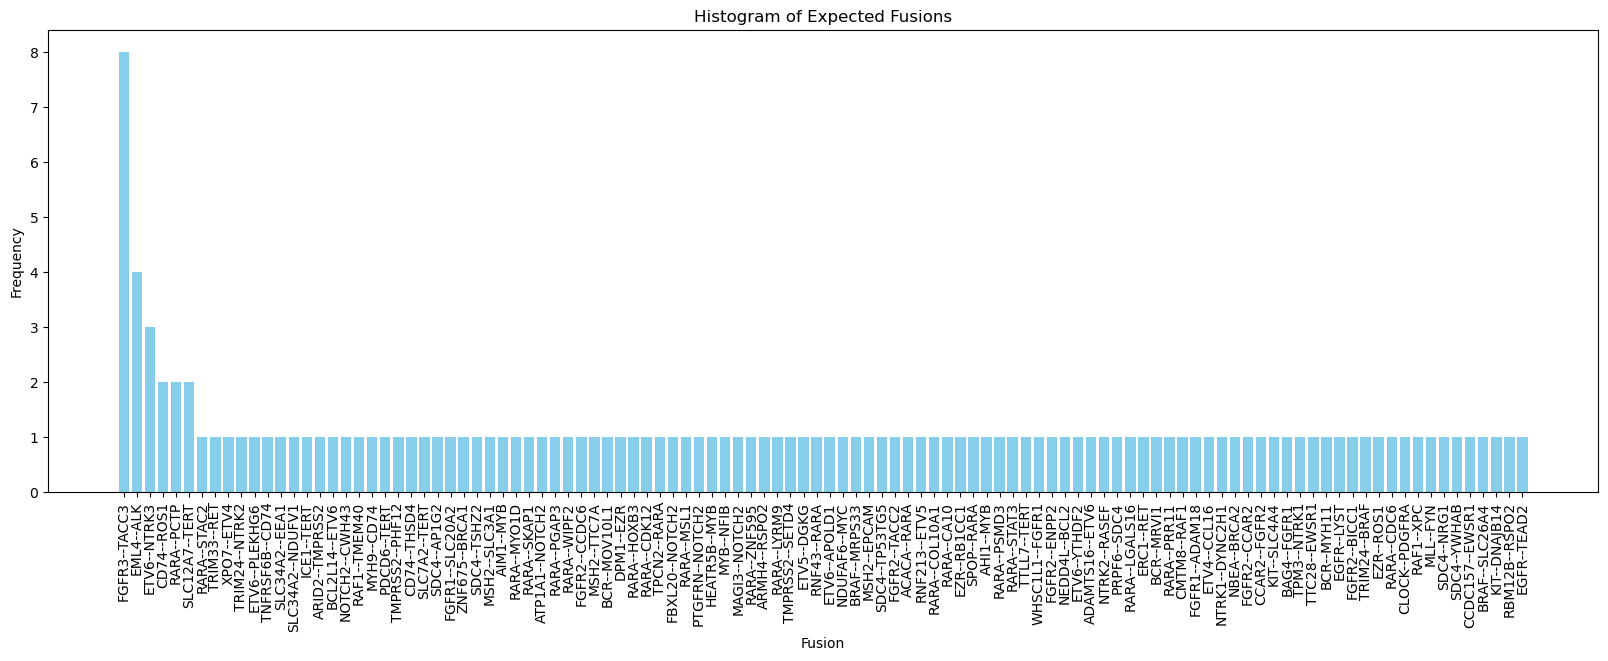

In [88]:
print(hist_fusion)
hist_gene = []
for fusion in hist_fusion:
    hist_gene = hist_gene + fusion.split("--")
print(hist_gene)

import matplotlib.pyplot as plt
from collections import Counter

# 示例列表

# 使用 Counter 统计元素频率
counter = Counter(hist_gene)
# counter = {key: value for key, value in counter.items() if value >= 3}
counter = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
df_counter = pd.DataFrame(list(counter.items()), columns=['Gene', 'Frequency'])
df_counter.to_csv(output_dir + f'counter_results_gene_{threshold}.csv', index=False)

# 提取元素和对应的频率
elements = list(counter.keys())
frequencies = list(counter.values())

# 绘制直方图
plt.figure(figsize=(25, 6))
plt.bar(elements, frequencies, color='skyblue')
plt.xlabel('Gene')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Histogram of Gene in Expected Fusions')
plt.show()

counter = Counter(hist_fusion)
# counter = {key: value for key, value in counter.items() if value >= 2}
counter = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
df_counter = pd.DataFrame(list(counter.items()), columns=['Fusion', 'Frequency'])
df_counter.to_csv(output_dir + f'counter_results_fusion_{threshold}.csv', index=False)

# 提取元素和对应的频率
elements = list(counter.keys())
frequencies = list(counter.values())

# 绘制直方图
plt.figure(figsize=(20, 6))
plt.bar(elements, frequencies, color='skyblue')
plt.xlabel('Fusion')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Histogram of Expected Fusions')
plt.show()


In [89]:
type.to_excel( f"type_{panel_name}.xlsx", index=False)

In [90]:
# 重合的基因

intersection_dict = {}
fusion_dict_final = {}
fusion_count = []
print(list(their_dict.keys()))
for index, row in mapping.iterrows():
    file_id = row["file_name"]
    submitter = row["submitter"]
    if submitter not in list(their_dict.keys()):
        print("Not found: ", submitter)
        continue
    if file_id not in list(fusion_dict.keys()):
        print("Not found: ", file_id)
        continue
    
    their_list = their_dict[submitter]
    our_list = fusion_dict[file_id]
    
    intersection = list(set(our_list).intersection(set(their_list)))
    intersection_dict[submitter] = intersection
    fusion_dict_final[submitter] = {}
    fusion_dict_final[submitter]["our"] = our_list
    fusion_dict_final[submitter]["their"] = their_list
    fusion_dict_final[submitter]["intersection"] = intersection
    count_fusion = {"sample": submitter, "inter": len(intersection), "our": len(our_list), "their": len(their_list)}
    fusion_count.append(count_fusion)
fusion_count = pd.DataFrame(fusion_count)
print(fusion_count)
fusion_count.to_csv(output_dir+"fusion_count_all_genes.csv", index=False)

['TCGA-OR-A5J1', 'TCGA-OR-A5J7', 'TCGA-OR-A5JS', 'TCGA-2F-A9KP', 'TCGA-BT-A2LA', 'TCGA-DK-A6B5', 'TCGA-FD-A43N', 'TCGA-GC-A6I3', 'TCGA-GV-A3QG', 'TCGA-K4-A3WV', 'TCGA-XF-A9T5', 'TCGA-A1-A0SB', 'TCGA-A2-A04U', 'TCGA-A2-A04W', 'TCGA-A2-A0CY', 'TCGA-A2-A0D4', 'TCGA-A2-A0ST', 'TCGA-A2-A0T3', 'TCGA-A2-A0YG', 'TCGA-A2-A3XS', 'TCGA-A7-A13D', 'TCGA-A7-A26G', 'TCGA-A7-A4SD', 'TCGA-A8-A08B', 'TCGA-A8-A09I', 'TCGA-A8-A0A7', 'TCGA-AN-A0FV', 'TCGA-AO-A12D', 'TCGA-AQ-A04H', 'TCGA-AR-A0TX', 'TCGA-AR-A254', 'TCGA-B6-A0IN', 'TCGA-B6-A0RH', 'TCGA-BH-A0B2', 'TCGA-BH-A0DD', 'TCGA-BH-A0W3', 'TCGA-BH-A18L', 'TCGA-BH-A18U', 'TCGA-BH-A202', 'TCGA-C8-A12L', 'TCGA-C8-A12Q', 'TCGA-C8-A131', 'TCGA-C8-A26X', 'TCGA-C8-A27A', 'TCGA-C8-A8HP', 'TCGA-D8-A13Z', 'TCGA-D8-A1XD', 'TCGA-E2-A155', 'TCGA-E2-A15A', 'TCGA-E2-A574', 'TCGA-EW-A1IW', 'TCGA-EW-A1J3', 'TCGA-EW-A1P3', 'TCGA-EW-A1PB', 'TCGA-EW-A6S9', 'TCGA-EW-A6SB', 'TCGA-GI-A2C9', 'TCGA-GM-A2DL', 'TCGA-LD-A7W5', 'TCGA-LD-A9QF', 'TCGA-C5-A1M7', 'TCGA-C5-A1MH', 'TCGA-E

In [91]:
# 重合的基因对
additional_fusions = set()
addition = []
add_count = []

intersection_dict = {}
fusion_dict_final = {}
fusion_count = []
# print(list(their_dict.keys()))
for index, row in mapping.iterrows():
    file_id = row["file_name"]
    submitter = row["submitter"]
    if submitter not in list(pair_dict_their.keys()):
        continue
    if file_id not in list(pair_dict_our.keys()):
        continue

    if submitter in duplicateRowsDF:
        # print("duplicateRowsDF: ", submitter)
        continue
    
    their_list = pair_dict_their[submitter]
    our_list = pair_dict_our[file_id]

    intersection = list(set(our_list).intersection(set(their_list)))
    intersection_dict[submitter] = intersection
    fusion_dict_final[submitter] = {}
    fusion_dict_final[submitter]["our"] = our_list
    fusion_dict_final[submitter]["their"] = their_list
    fusion_dict_final[submitter]["intersection"] = intersection
    fusion_dict_final[submitter]["undetected"] = list(set(their_list) - set(intersection))
    add = set(our_list) - set(intersection)
    # print(len(add) ==(len(our_list) - len(intersection)) )
    add_count.append(len(add))
    addition = addition + list(add)
    additional_fusions = additional_fusions.union(add)

    count_fusion = {"sample": submitter, "inter": len(intersection), "our": len(our_list), "their": len(their_list)}
    fusion_count.append(count_fusion)
fusion_count = pd.DataFrame(fusion_count)
# duplicateRowsDF = fusion_count[fusion_count['sample'].duplicated(keep=False)]
# # print(duplicateRowsDF)
# duplicateRowsDF = duplicateRowsDF["sample" ].tolist()  
fusion_count["extra"] = fusion_count["our"] - fusion_count["inter"]
fusion_count["rate"] = fusion_count["inter"] / fusion_count["their"]
fusion_count.to_excel(output_dir+f"count_pair_{threshold}no{this_cancer}.xlsx", index=False)
print(len(additional_fusions))
print(additional_fusions)
print(len((addition)))
print(f"extra fusions: {len(set(addition))}"  )
intersum = sum(fusion_count["inter"])
theirsum = sum(fusion_count["their"])
interlist = fusion_count["inter"]
theirlist = fusion_count["their"]
print(f"overall detect rate: {intersum}/{theirsum} = {intersum/theirsum:.1%}")
print(f"average detect rate by sample: {average(interlist/theirlist):.1%}")

26
{'FBXO9--CD74', 'RARA--P3H4', 'TMPRSS2--AP000688.14', 'MSH2--RP4-734G22.3', 'ROS1--FBXO9', 'RARA--CDC6', 'IGH--CD74', 'EGFR--FGGY', 'EGFR--LINC01445', 'RARA--SEPT9', 'EGFR--SEC61G', 'RARA--TSPYL4', 'TMEM263--EZR', 'RARA--RP11-220C2.1', 'RARA--GAST', 'ROS1--CD74', 'RARA--BIVM', 'BRAF--DPP6', 'RARA--ERBB2', 'FGFR1--LETM2', 'PVT1--MYC', 'RARA--NEAT1', 'CASC11--MYC', 'SLC34A2--RP11-302F12.3', 'LYRM9--RARA', 'MYB--UMAD1'}
29
extra fusions: 26
overall detect rate: 99/123 = 80.5%
average detect rate by sample: 79.5%


average undetected Junction Spanning Reads: 4.583333333333333
average detected SpanningFragCount: 205.4848484848485
[1, 4, 5, 4, 1, 1, 3, 1, 9, 1, 4, 2, 3, 30, 1, 1, 1, 3, 8, 2, 4, 19, 1, 1]
[34, 8, 21, 10, 3, 11, 15, 40, 260, 1, 1727, 21, 5, 4, 14, 6, 19, 10, 61, 5, 1614, 13, 56, 136, 42, 12, 9, 60, 23, 51, 21, 9, 18, 16, 9, 71, 8, 8, 56, 7, 138, 26, 8, 715, 8, 3, 230, 3, 15, 34, 48, 192, 87, 1472, 31, 31, 104, 27, 8, 62, 19, 4, 70, 425, 15, 4, 6, 12, 21, 2484, 13, 16, 6, 1, 16, 11, 25, 497, 18, 16, 50, 15, 54, 6, 73, 175, 173, 13, 33, 2, 2, 3953, 20, 35, 1, 20, 4264, 7, 12]


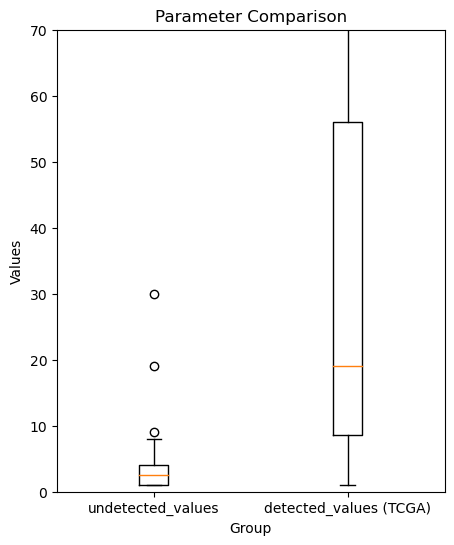

In [92]:
undetected_values = []
detected_values = []
our_detected_values = []
parameter_un = "Junction Spanning Reads"
# parameter_un = "Discordant Read Pairs"
parameter_de = "SpanningFragCount"

for key, value in fusion_dict_final.items():
    undetected = fusion_dict_final[key]["undetected"]
    detected = fusion_dict_final[key]["intersection"]
    for item in undetected:
        # print(item)
        genea = item.split("--")[0]
        # print(genea)
        geneb = item.split("--")[1]
        # print(geneb)
        if their_df.loc[(their_df['sample'] == key)&(their_df['Gene_A'] == genea)&(their_df['Gene_B'] == geneb), parameter_un].tolist() != []:
            undetected_values.append(their_df.loc[(their_df['sample'] == key)&(their_df['Gene_A'] == genea)&(their_df['Gene_B'] == geneb), parameter_un].tolist()[0])
    for item in detected:
        genea = item.split("--")[0]
        geneb = item.split("--")[1]

        file_id = mapping.loc[mapping['submitter'] == key, 'file_name'].tolist()[0]
        detected_values.append(their_df.loc[(their_df['sample'] == key)&(their_df['Gene_A'] == genea) & (their_df['Gene_B'] == geneb), parameter_un].tolist()[0])
        our_detected_values.append(our_df.loc[(our_df['sample'] == file_id)&(our_df['#FusionName'] == item), parameter_de].tolist()[0])
print(f"average undetected {parameter_un}: {average(undetected_values)}")
print(f"average detected {parameter_de}: {average(detected_values)}")
print(undetected_values)
print(detected_values)

# 化成箱线图
import matplotlib.pyplot as plt
import seaborn as sns

data = [undetected_values, detected_values] # , our_detected_values, 'detected_values (ours)'

# 创建箱线图
plt.figure(figsize=(5, 6))
plt.boxplot(data, labels=['undetected_values', 'detected_values (TCGA)'])
plt.title('Parameter Comparison')
plt.xlabel('Group')
plt.ylabel('Values')
plt.ylim(0, 70)

# 显示图形
plt.show()


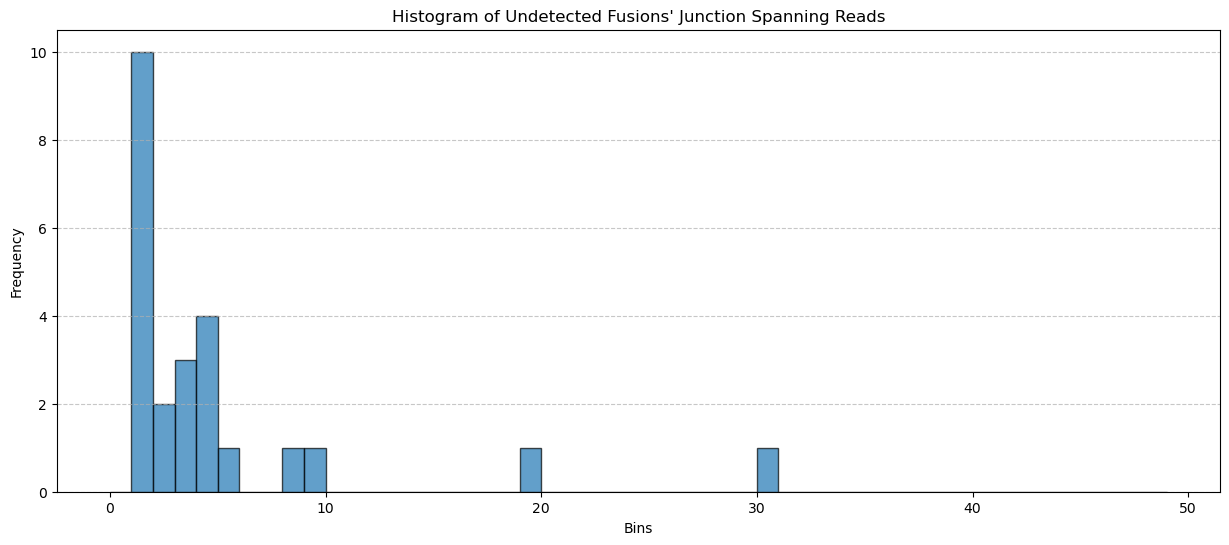

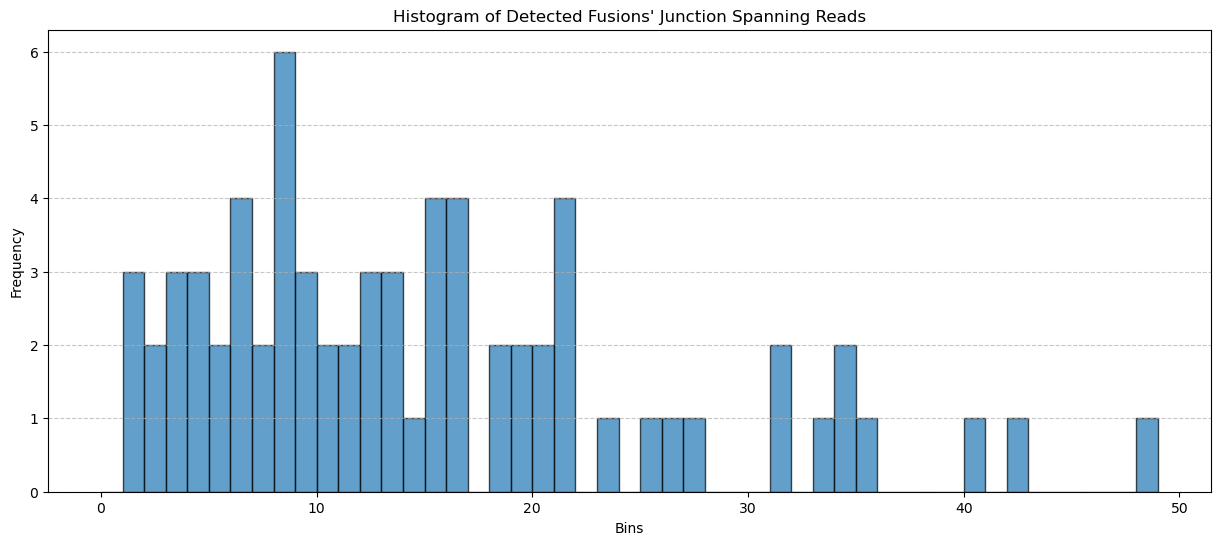

In [93]:
import numpy as np

# 创建区间
bins = np.arange(0, 50, 1)  # 这里的区间宽度为2，可根据实际情况调整

# 绘制直方图
plt.figure(figsize=(15, 6))

plt.hist(undetected_values, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Undetected Fusions\' Junction Spanning Reads')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 创建区间
# bins = np.arange(0, max(detected_values) + 2, 2)  # 这里的区间宽度为2，可根据实际情况调整

# 绘制直方图
plt.figure(figsize=(15, 6))

plt.hist(detected_values, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Detected Fusions\' Junction Spanning Reads')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [94]:
for index, row in our_df.iterrows():
    matching_rows = mapping.loc[mapping['file_name'] == row['sample'], 'submitter'].tolist()

    if matching_rows:
        our_df.at[index, 'submitter'] = matching_rows[0]
    else:
        # Handle the case when no matching row is found
        our_df.at[index, 'submitter'] = None  # or any other default value

our_df.dropna(subset=['submitter'], inplace=True)
print(our_df["submitter"].tolist()) 
their_df["Gene_A--Gene_B"] = their_df["Gene_A"].astype(str) + "--" + their_df["Gene_B"].astype(str)
# print(their_df.head())
# print(our_df.head())
our_df.sort_values(by=['submitter', '#FusionName'], inplace=True)
their_df.sort_values(by=['sample', 'Gene_A--Gene_B'], inplace=True)
our_df.to_excel(output_dir+"our_df.xlsx", index=False)
their_df.to_excel(output_dir+"their_df.xlsx", index=False)

merge_df = pd.merge(our_df, their_df, how='inner', left_on=['#FusionName'], right_on=[ 'Gene_A--Gene_B'])
print(merge_df.head())
merge_df.to_excel(output_dir+"merge_df.xlsx", index=False)

['TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-C8-A12Q', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-C8-A12Q', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-C8-A12Q', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-C8-A12Q', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-C8-A12Q', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-C8-A12Q', 'TCGA-AR-A0TX', 'TCGA-C8-A12Q', 'TCGA-69-7979', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-69-7979', 'TCGA-C8-A12Q', 'TCGA-VQ-A8E2', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-C8-A12Q', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-AR-A0TX', 'TCGA-C8-A12Q', 'TCGA-AR-A0TX', 'TCGA-C8-A12Q', 'TCGA-AR-A0TX', 'TCGA-A

In [95]:
their_df.head()

# check_sample = "TCGA-96-8169"
# check_sample2 = mapping[mapping["submitter"] == check_sample]["file_name"].tolist()[0]
# print(pair_dict_their[check_sample])
# print(pair_dict_our[check_sample2])
# print(list(set(pair_dict_their[check_sample]).intersection(set(pair_dict_our[check_sample2]))))

,Gene_A,Gene_B,Discordant Read Pairs,Junction Spanning Reads,Number of Junctions,sample,Gene_A--Gene_B
9941,SLC34A2,NDUFV1,2,5,1,TCGA-05-4405,SLC34A2--NDUFV1
6756,TAOK1,RARA,2,8,1,TCGA-06-0141,TAOK1--RARA
6800,EGFR,ERP44,11,34,2,TCGA-06-0744,EGFR--ERP44
6806,EGFR,2017-09-14 00:00:00,6,229,1,TCGA-06-0750,EGFR--2017-09-14 00:00:00
6827,CCDC127,TERT,3,8,2,TCGA-06-2564,CCDC127--TERT


In [96]:
our_df.head()

,#FusionName,JunctionReadCount,SpanningFragCount,sample,submitter
36,AFMID--TNRC6C,5,22,bc037eb7-5afa-4730-b896-23bf21a31641,TCGA-69-7979
39,APOPT1--MARK3,5,41,bc037eb7-5afa-4730-b896-23bf21a31641,TCGA-69-7979
36,BRI3BP--UBC,1,2,a4455185-5506-4392-bd54-5f9cda2274d2,TCGA-69-7979
36,C17orf62--TRAPPC6A,2,0,d820ac02-a30e-437b-b20a-3e92705b7b81,TCGA-69-7979
36,C22orf34--HDAC10,3,10,ff5adae0-cf8d-4ed1-9e5e-03a8bb53688f,TCGA-69-7979


In [97]:
our_df = pd.DataFrame()
count = 0
for file in files:
    df = pd.read_csv(os.path.join(folder, file), sep="\t")
    df = df[['#FusionName', 'JunctionReadCount', 'SpanningFragCount']]
    df['#FusionName'] = df['#FusionName'].apply(lambda x: x.replace("-@-ext", "") if isinstance(x, str) else x)
    df['#FusionName'] = df['#FusionName'].apply(lambda x: x.replace("@-ext", "") if isinstance(x, str) else x)
    df = df[~df['#FusionName'].duplicated(keep='first')]
    df = df[~df['#FusionName'].isin(['C10orf68--CCDC7', 'CCDC7--C10orf68'])]
    sample_name = file.replace(suffix, "")
    df["sample"] = sample_name
    our_df = pd.concat([our_df, df], axis=0)
    # print(our_df.shape)
    count = count + 1
    # if count > 25:
    #     break
    # print(stop)
    # JunctionReadCount  SpanningFragCount
    

In [98]:
print(len(panel2))
F1_fusion_panel_df =[]
print(panel2)
count_gene = []
for index, row in mapping.iterrows():
    file_id = row["file_name"]
    submitter = row["submitter"]
    if submitter not in list(their_dict.keys()):
        # print("Not found: ", submitter)
        continue
    if file_id not in list(fusion_dict.keys()):
        # print("Not found: ", file_id)
        continue
    
    their_list = their_dict[submitter]
    their_list = list(set(their_list).intersection(set(panel2)))
    our_list = fusion_dict[file_id]

    this_F1 = {}
    this_F1["sample"] = submitter
    for gene in their_list:
        this_F1[gene] = (gene in our_list)
        if gene not in count_gene:
            count_gene.append(gene)

    F1_fusion_panel_df.append(this_F1)
F1_fusion_panel_df = pd.DataFrame(F1_fusion_panel_df)
# print(F1_fusion_panel_df)
F1_fusion_panel_df.set_index("sample", inplace=True)

F1_fusion_panel_df.to_excel(output_dir+f"F1_fusion_panel_filter_allno{this_cancer}.xlsx", index=True)
print(F1_fusion_panel_df.shape)

print(len(count_gene))
print(count_gene)
print(F1_fusion_panel_df.columns[F1_fusion_panel_df.all()].to_list())
print(len(F1_fusion_panel_df.columns[F1_fusion_panel_df.all()].to_list()))

# print(len(set(count_gene).intersection(set(panel2))))

36
['RARA', 'ETV6', 'FGFR3', 'TERT', 'FGFR1', 'SDC4', 'ALK', 'FGFR2', 'CD74', 'MSH2', 'NOTCH2', 'EZR', 'TMPRSS2', 'BRAF', 'RAF1', 'ROS1', 'MYB', 'RET', 'EGFR', 'ETV4', 'NTRK1', 'KIT', 'NTRK2', 'ETV5', 'SLC34A2', 'RSPO2', 'EWSR1', 'BCR', 'MLL', 'BRCA1', 'PDGFRA', 'MYC', 'BCL2', 'BRCA2', 'NUTM1', 'TERC']
(117, 34)
34
['RARA', 'FGFR3', 'RET', 'ALK', 'ETV4', 'NTRK2', 'ETV6', 'CD74', 'SLC34A2', 'ROS1', 'TERT', 'TMPRSS2', 'NOTCH2', 'RAF1', 'SDC4', 'FGFR1', 'BRCA1', 'MSH2', 'MYB', 'FGFR2', 'BCR', 'EZR', 'RSPO2', 'ETV5', 'MYC', 'BRAF', 'BCL2', 'NTRK1', 'BRCA2', 'KIT', 'EWSR1', 'EGFR', 'PDGFRA', 'MLL']
['FGFR3', 'RET', 'ALK', 'ETV6', 'ROS1', 'TMPRSS2', 'NOTCH2', 'BRCA1', 'MSH2', 'FGFR2', 'EZR', 'MYC', 'NTRK1', 'BRCA2', 'EWSR1', 'EGFR', 'PDGFRA']
17


In [99]:
# 重合的基因对
fusion_pair_df =[]
count_gene = []
for index, row in mapping.iterrows():
    file_id = row["file_name"]
    submitter = row["submitter"]
    if submitter not in list(their_dict.keys()):
        # print("Not found: ", submitter)
        continue
    if file_id not in list(fusion_dict.keys()):
        # print("Not found: ", file_id)
        continue
    
    their_list = pair_dict_their[submitter]
    # their_list = list(set(their_list).intersection(set(panel2)))
    our_list = pair_dict_our[file_id]

    this_F1 = {}
    this_F1["sample"] = submitter
    for gene in their_list:
        this_F1[gene] = (gene in our_list)
        if gene not in count_gene:
            count_gene.append(gene)

    fusion_pair_df.append(this_F1)
fusion_pair_df = pd.DataFrame(fusion_pair_df)
# print(fusion_pair_df)
fusion_pair_df.set_index("sample", inplace=True)

fusion_pair_df.to_csv(output_dir+f"pair_df_{threshold}no{this_cancer}.csv", index=True)
print(fusion_pair_df.shape)
print(fusion_pair_df.any().sum())
print(len(count_gene))


(117, 108)
85
108


In [100]:
non_empty_counts = F1_fusion_panel_df.count()
true_counts = F1_fusion_panel_df[F1_fusion_panel_df == True].count()
false_counts = F1_fusion_panel_df[F1_fusion_panel_df == False].count()
result_df = pd.DataFrame({'NonEmptyCount': non_empty_counts, 'TrueCount': true_counts, 'FalseCount': false_counts})
result_df.to_csv(output_dir+f"result_count_df_{threshold}.csv", index=True)
# print(F1_fusion_panel_df.count())
# print(F1_fusion_panel_df[F1_fusion_panel_df == True].count())
# print(F1_fusion_panel_df[F1_fusion_panel_df == False].count())

In [101]:
print(just_to_stop)
# content under this line is to check the distribution of parameters

NameError: name 'just_to_stop' is not defined

In [ ]:
bigdata['Sample'] = bigdata['Sample'].apply(lambda x: '-'.join(x.split('-')[:3]))

analysis = pd.DataFrame(columns=bigdata.columns)

for index, row in F1_fusion_panel_df.iterrows():   

    if row.eq(False).any():
        false_columns = row.index[row.eq(False)].to_list()
        # print(false_columns)
        df = bigdata[bigdata['Sample'] == index]
        for gene in false_columns:
            if gene in df['Gene_A'].values:
                filtered_df = df[df['Gene_A'] == gene]
                analysis = pd.concat([analysis,filtered_df ], axis=0)
            if gene in df['Gene_B'].values:
                filtered_df = df[df['Gene_B'] == gene]
                analysis = pd.concat([analysis,filtered_df ], axis=0)
analysis.reset_index(drop=True, inplace=True)
print(analysis)
analysis.to_csv("undetected_fusions.csv", index=False)

          Sample    Gene_A   Gene_B Discordant Read Pairs  \
0   TCGA-55-A493  TNFRSF6B     CD74                     2   
1   TCGA-55-7727   SLC34A2     EEA1                     2   
2   TCGA-05-4405   SLC34A2   NDUFV1                     2   
3   TCGA-CJ-4635      RAF1   TMEM40                    21   
4   TCGA-A3-A6NL      MYH9     CD74                     2   
5   TCGA-DD-A4NA      CD74    THSD4                     2   
6   TCGA-97-8171      SDC4    AP1G2                     2   
7   TCGA-69-8255     FGFR1  SLC20A2                     3   
8   TCGA-EW-A1P3      AIM1      MYB                    11   
9   TCGA-C8-A27A       BCR  MOV10L1                     2   
10  TCGA-AY-6196     ARMH4    RSPO2                     3   
11  TCGA-CM-6167     RNF43     RARA                     4   
12  TCGA-AQ-A04H    RNF213     ETV5                    12   
13  TCGA-C8-A131     TTLL7     TERT                     9   
14  TCGA-GM-A2DL    NEDD4L     BCL2                     6   
15  TCGA-D8-A1XD     NTR

Index(['Sample', 'Gene_A', 'Gene_B', 'Discordant Read Pairs',
       'Junction Spanning Reads', 'Number of Junctions', 'sample'],
      dtype='object')


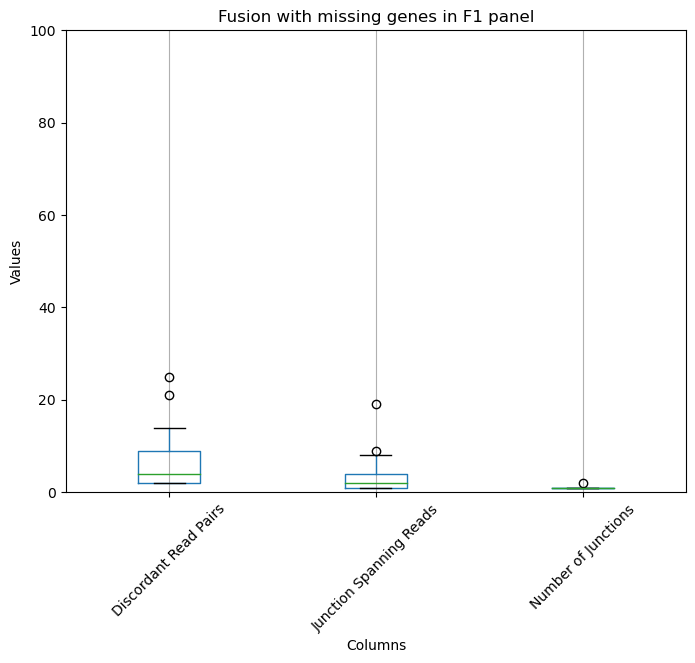

In [ ]:
# analysis画箱线图：
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# 画箱线图：
print(analysis.columns)
df = analysis

df['Discordant Read Pairs'] = pd.to_numeric(df['Discordant Read Pairs'], errors='coerce')
df['Junction Spanning Reads'] = pd.to_numeric(df['Junction Spanning Reads'], errors='coerce')
df['Number of Junctions'] = pd.to_numeric(df['Number of Junctions'], errors='coerce')


columns_to_plot = ['Discordant Read Pairs', 'Junction Spanning Reads', 'Number of Junctions']

# 使用 Matplotlib 绘制箱线图
plt.figure(figsize=(8, 6))
df.boxplot(column=columns_to_plot)
plt.ylim(0,100)
plt.title('Fusion with missing genes in F1 panel')
plt.ylabel('Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.grid(axis='y')

# 显示箱线图
plt.show()


(124, 7)


/tmp/ipykernel_190321/2707727397.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Discordant Read Pairs'] = pd.to_numeric(df['Discordant Read Pairs'], errors='coerce')
/tmp/ipykernel_190321/2707727397.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Junction Spanning Reads'] = pd.to_numeric(df['Junction Spanning Reads'], errors='coerce')
/tmp/ipykernel_190321/2707727397.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

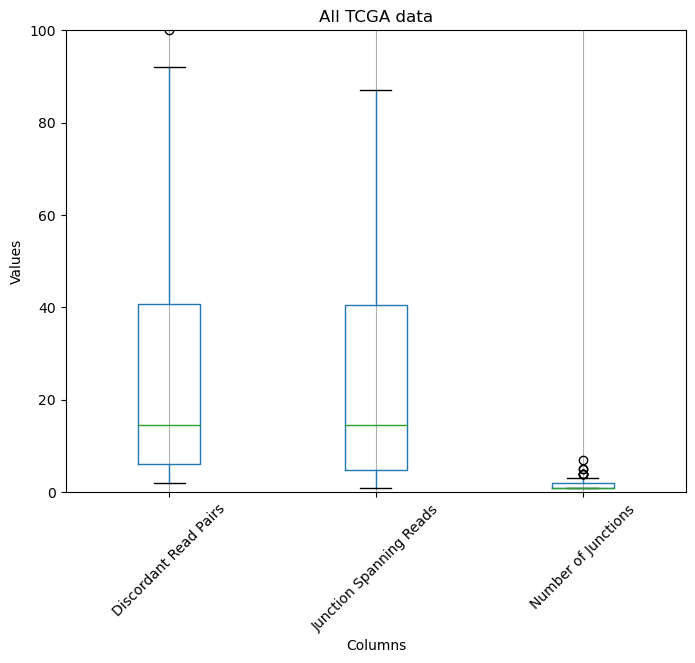

In [ ]:
sample_list = mapping["submitter"].tolist()
df = bigdata[bigdata["Sample"].isin(sample_list)]
print(df.shape)

df['Discordant Read Pairs'] = pd.to_numeric(df['Discordant Read Pairs'], errors='coerce')
df['Junction Spanning Reads'] = pd.to_numeric(df['Junction Spanning Reads'], errors='coerce')
df['Number of Junctions'] = pd.to_numeric(df['Number of Junctions'], errors='coerce')


columns_to_plot = ['Discordant Read Pairs', 'Junction Spanning Reads', 'Number of Junctions']

# 使用 Matplotlib 绘制箱线图
plt.figure(figsize=(8, 6))
df.boxplot(column=columns_to_plot)
plt.ylim(0,100)

plt.title('All TCGA data')
plt.ylabel('Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.grid(axis='y')

# 显示箱线图
plt.show()